<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/residuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residuals Analysis

*Author: Alexander Del Toro Barba*

## What are residuals?

For most (time series) models, the residuals are difference between observation and its corresponding estimated (fitted) value:

$e_{t} = y_{t} - \hat{y}_{t}$

## Why is it important to analyze residuals?

Residuals are useful in checking whether a model has adequately captured the information in the data. In a good model the residuals are stationary. However one can classify the stationarity criteria in two distinct groups for residual analysis:

A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.

2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

If either of these properties is not satisfied, then the forecasting method can be modified to give better forecasts. Adjusting for bias is easy: if the residuals have mean m, then simply add m to all forecasts and the bias problem is solved. Fixing the correlation problem is harder, and we will not address it until Chapter 9.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

3. The residuals have constant variance.

4. The residuals are normally distributed.

These two properties make the calculation of prediction intervals easier (see Section 3.5 for an example). However, a forecasting method that does not satisfy these properties cannot necessarily be improved. Sometimes applying a Box-Cox transformation may assist with these properties, but otherwise there is usually little that you can do to ensure that your residuals have constant variance and a normal distribution. Instead, an alternative approach to obtaining prediction intervals is necessary. Again, we will not address how to do this until later in the book.

https://otexts.com/fpp2/residuals.html
https://otexts.com/fpp2/prediction-intervals.html

# Import Libraries

In [1]:
# Import packages
import numpy as np
import sklearn
from decimal import *
from numpy import linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import collections
import datetime
import matplotlib
from scipy import stats
import scipy.stats as stats
import matplotlib.pylab as py
import matplotlib.pyplot as plt
from numpy import sqrt
from copy import copy
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels
from statsmodels.tsa.stattools import adfuller
from numpy import log

# Regression Model (Linear)

## Import Data

In [0]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/usa_housing.csv'
regression = pd.read_csv(url)

## Explore Data

In [3]:
regression.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


In [4]:
regression.describe()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,68583.108984,5.977222,6.987792,3.981330,36163.516039,1.232073e+06
std,10657.991214,0.991456,1.005833,1.234137,9925.650114,3.531176e+05
min,17796.631190,2.644304,3.236194,2.000000,172.610686,1.593866e+04
25%,61480.562388,5.322283,6.299250,3.140000,29403.928702,9.975771e+05
50%,68804.286404,5.970429,7.002902,4.050000,36199.406689,1.232669e+06
75%,75783.338666,6.650808,7.665871,4.490000,42861.290769,1.471210e+06
max,107701.748378,9.519088,10.759588,6.500000,69621.713378,2.469066e+06


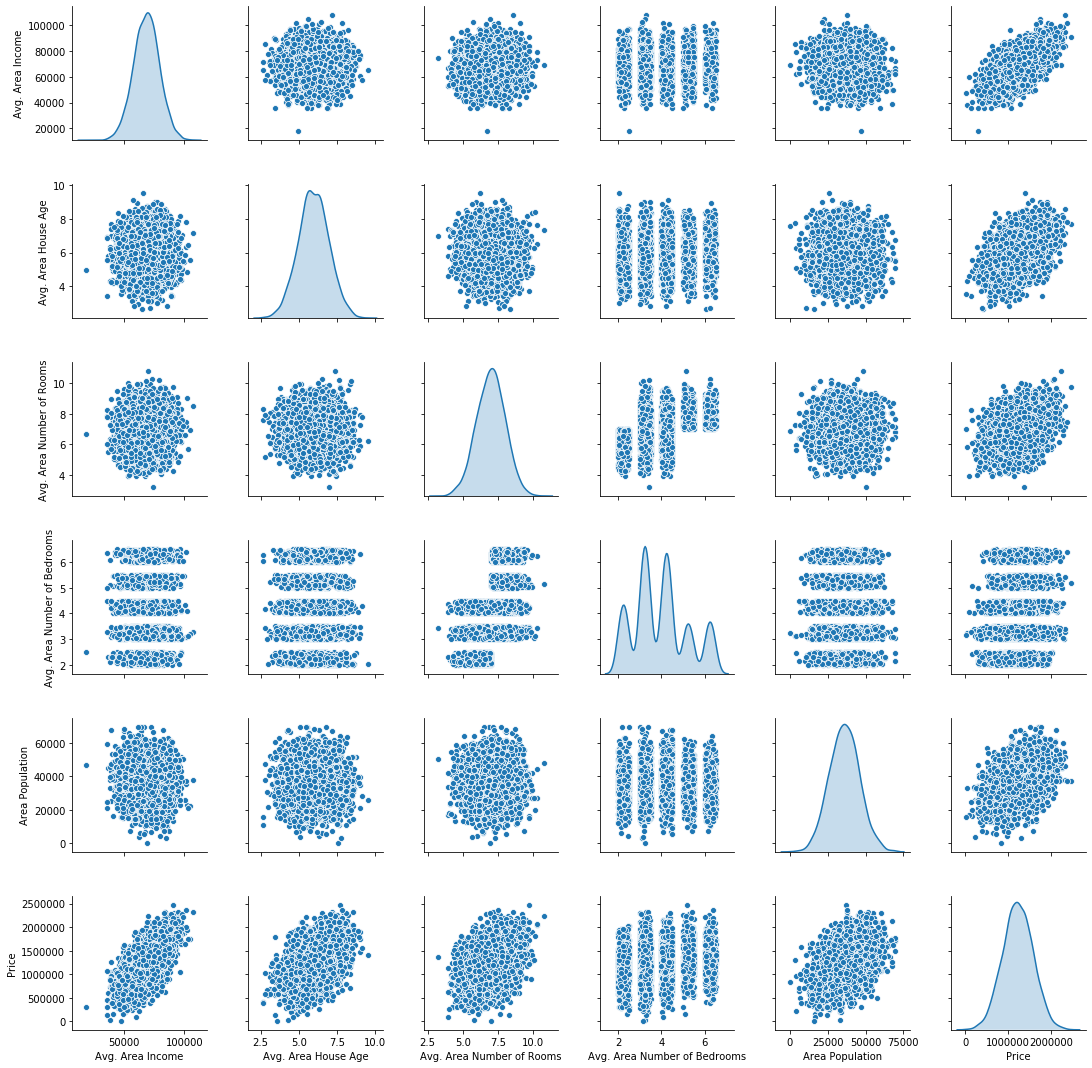

In [5]:
sns.pairplot(regression, diag_kind='kde')

## Model Training

**Set X and Y Arrays**

In [0]:
X = regression[['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
               'Avg. Area Number of Bedrooms', 'Area Population']]
y = regression['Price']

**Train & Test Split**

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

**Create & Train Model**

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
lm = LinearRegression()

In [11]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Evaluate Model**

In [12]:
# print the intercept
print(lm.intercept_)

-2640159.796853739


In [13]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Avg. Area Income,21.528276
Avg. Area House Age,164883.282027
Avg. Area Number of Rooms,122368.678027
Avg. Area Number of Bedrooms,2233.801864
Area Population,15.150420


Interpreting the coefficients:

- Holding all other features fixed, a 1 unit increase in **Avg. Area Income** is associated with an **increase of \$21.52 **.
- Holding all other features fixed, a 1 unit increase in **Avg. Area House Age** is associated with an **increase of \$164883.28 **.
- Holding all other features fixed, a 1 unit increase in **Avg. Area Number of Rooms** is associated with an **increase of \$122368.67 **.
- Holding all other features fixed, a 1 unit increase in **Avg. Area Number of Bedrooms** is associated with an **increase of \$2233.80 **.
- Holding all other features fixed, a 1 unit increase in **Area Population** is associated with an **increase of \$15.15 **.

**Run predictions from model**

In [0]:
predictions_regression = lm.predict(X_test)

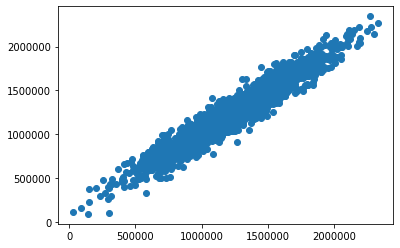

In [15]:
plt.scatter(y_test,predictions_regression)

**Regression Evaluation Metrics**

In [0]:
from sklearn import metrics

In [17]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions_regression))
print('MSE:', metrics.mean_squared_error(y_test, predictions_regression))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_regression)))

MAE: 82288.22251914928
MSE: 10460958907.208244
RMSE: 102278.82922290538


# Residuals Analysis - Regression

## Residuals Summary

In [0]:
# Define residuals
residuals_regression = (y_test-predictions_regression)

## Distribution Tests

If residuals are not normally distributed, one has to take this into consideration in the prediction windows.

**Distribution Plot**

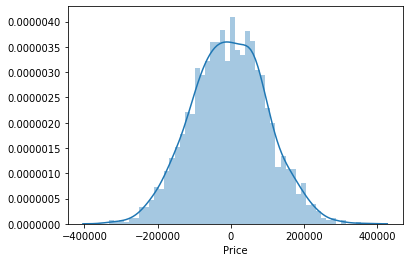

In [19]:
sns.distplot((residuals_regression),bins=50);

Visual inspection of distribution: looks very much normally distributed.

**Quantile Quantile Plot**

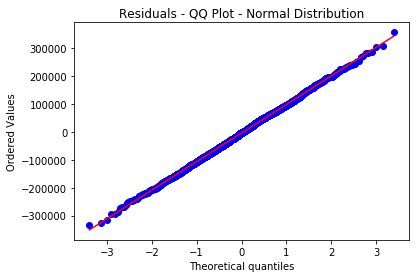

In [20]:
stats.probplot(residuals_regression, dist="norm", plot=plt)
plt.title('Residuals - QQ Plot - Normal Distribution')
plt.show()

Almost perfect in line with normal distribution.

**Anderson-Darling Test**

In [21]:
# Anderson-Darling Test for Normal Distribution
stats.anderson(residuals_regression)

AndersonResult(statistic=0.3481433493629993, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

**Jarque-Bera Test**

In [22]:
# Jarque-Bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution
# Null hypothesis: sample is normal distributed. JB(PValue<0.05)= Reject Ho (Non-Normal Distribution)
stats.jarque_bera(residuals_regression)

(0.9246681153093295, 0.6298119113062501)

P-Value not smaller than 0.05. Do not reject H0 that data is normallz distributed.

**Kolmogorov-Smirnov Test**

In [23]:
# Kolmogorov-Smirnov Test
stats.kstest(residuals_regression, 'norm')

KstestResult(statistic=0.512, pvalue=0.0)


---
## Stationary Tests



This is important because...

**Augmented Dickey Fuller Test**

In [24]:
# Augmented Dickey Fuller Test
# H0: There is a unit root for the series (non stationary)
# Test for no constant, no trend. Reject H0 if p-value of less than 5%.
statsmodels.tsa.stattools.adfuller(residuals_regression, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-44.07845744172575,
 0.0,
 0,
 1999,
 {'1%': -2.566859366887045,
  '10%': -1.616687809570532,
  '5%': -1.9411352053667381},
 51115.547357172356)

P-value is zero. Reject H0. Residuals are not non-stationary.

**KPSS - Trend Stationary Test**

In [25]:
# KPSS - Trend Stationary Test
# H0 = Deterministic Trend. H1 = Non-Stationary (Unit Root). Reject H0 if p-value of less than 5% 
statsmodels.tsa.stattools.kpss(residuals_regression, regression='ct', lags='auto', store=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.03552040142555443,
 0.1,
 9,
 {'1%': 0.216, '10%': 0.119, '2.5%': 0.176, '5%': 0.146})

P-value larger than 0.05. Do not reject H0. Residuals are not non-stationary.

**KPSS - Level Stationary Test**

In [26]:
# KPSS - Level Stationary Test
# H0 = Stationary (Stochastic Trend). H1 = Non-Stationary (Unit Root). Reject H0 if p-value of less than 5%
statsmodels.tsa.stattools.kpss(residuals_regression, regression='c', lags='auto', store=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.04915192673147727,
 0.1,
 9,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

P-value larger than 0.05. Do not reject H0. Residuals are not non-stationary.

---
## Autocorrelation Tests

This is importane because..

**Lag Plot**

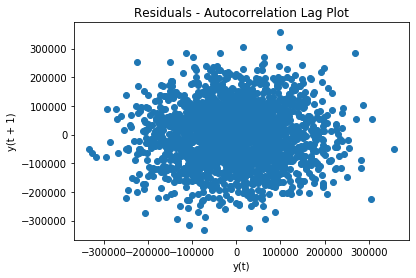

In [27]:
lag_plot(residuals_regression)
plt.title('Residuals - Autocorrelation Lag Plot')
plt.show()

**Autocorrelation Plot**

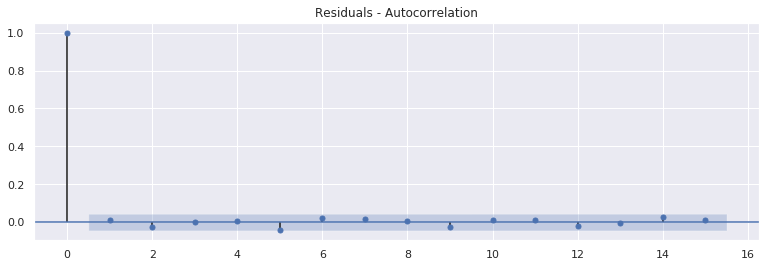

In [28]:
sns.set(rc={'figure.figsize':(13, 4)})
sm.graphics.tsa.plot_acf(residuals_regression.squeeze(), lags=15)
plt.title('Residuals - Autocorrelation')
plt.show()

**Partial Autocorrelation Plot**

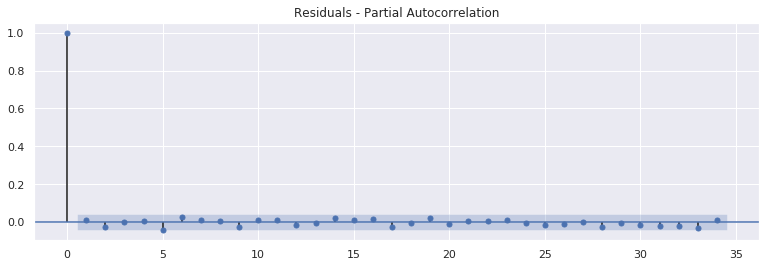

In [29]:
# Partial Autocorrelation Plot
plot_pacf(residuals_regression)
plt.title('Residuals - Partial Autocorrelation')
plt.show()

**Durbin-Watson Test**

In [30]:
# Durbin-Watson test to assess autocorrelation
# The null hypothesis of the test is that there is no serial correlation
# This statistic will always be between 0 and 4. 
# The closer to 0 the statistic, the more evidence for positive serial correlation. 
# The closer to 4, the more evidence for negative serial correlation.
statsmodels.stats.stattools.durbin_watson(residuals_regression, axis=0)

1.9720340796089788

Almost at r=2, which means no serial autocorrelation.

# Time Series Model (Naive)

## Import Data

In [0]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
timeseries = pd.read_csv(url)

timeseries = timeseries.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
timeseries = timeseries.set_index('Date')

## Explore Data

In [32]:
timeseries.head()

,Close
Date,
2010-02-01,265.514771
2010-02-02,264.568329
2010-02-03,269.400208
2010-02-04,262.406433
2010-02-05,264.653015


In [33]:
timeseries.describe()

,Close
count,2516.000000
mean,652.587282
std,331.360307
min,217.220810
25%,322.143769
50%,567.298034
75%,937.145019
max,1486.650024


Text(0.5, 0, 'Time step')

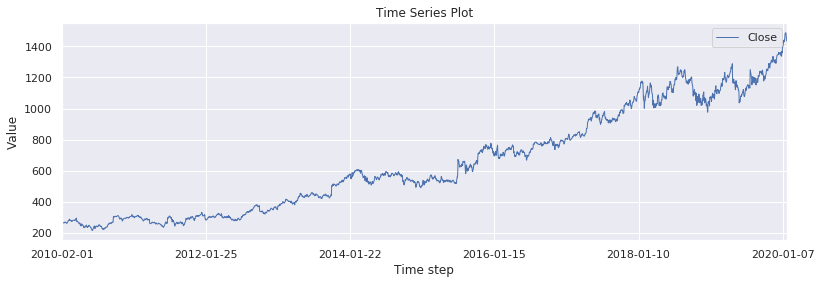

In [34]:
df = timeseries
sns.set(rc={'figure.figsize':(13, 4)})
df.plot(linewidth=1.0,title='Time Series Plot')
plt.ylabel('Value')
plt.xlabel('Time step')

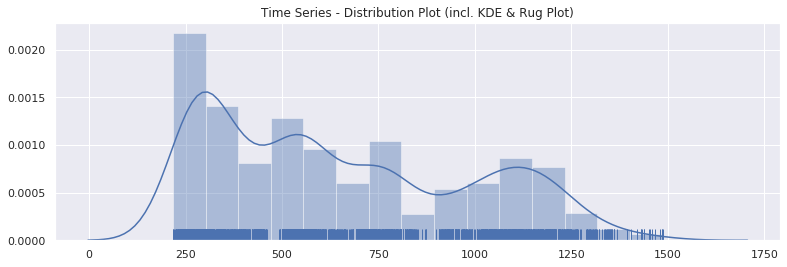

In [35]:
df = timeseries
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((df), hist=True, rug=True).set_title('Time Series - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

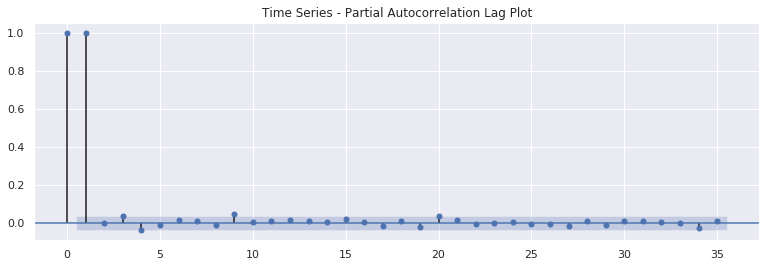

In [36]:
plot_pacf(timeseries)
plt.title('Time Series - Partial Autocorrelation Lag Plot')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


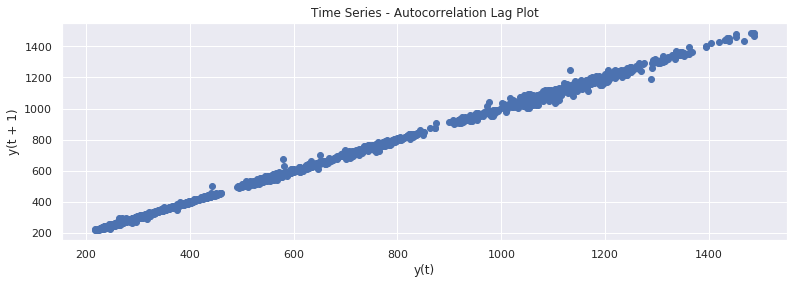

In [37]:
lag_plot(timeseries)
plt.title('Time Series - Autocorrelation Lag Plot')
plt.show()

One can predict next day price by todays price in a good amount. Rest maybe (Gaussian?) noise -> needs to be modeled and checked.

## Model Training

In [38]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

# Create lagged dataset
values = DataFrame(timeseries.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

          t-1         t+1
0         NaN  265.514771
1  265.514771  264.568329
2  264.568329  269.400208
3  269.400208  262.406433
4  262.406433  264.653015


In [0]:
# Train and Test Set
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [0]:
# persistence model
def model_persistence(x):
	return x

In [41]:
# walk-forward validation
predictions_timeseries = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions_timeseries.append(yhat)
test_score = mean_squared_error(test_y, predictions_timeseries)
print('Test MSE: %.3f' % test_score)

Test MSE: 238.637


In [42]:
from statsmodels.tsa.ar_model import AR

# fit model
model = AR(timeseries)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(timeseries), len(timeseries))
print(yhat)

2516    1459.000122
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


# Residuals Analysis - Time Series

## Residuals Summary

In [0]:
# Define residuals
residuals_timeseries = (test_y - predictions_timeseries)

In [0]:
# Convert from numpy.ndarray into pandas.DataFrame
residuals_timeseries = pd.DataFrame(residuals_timeseries)

In [58]:
residuals_timeseries.head()

,0
0,2.679993
1,8.619995
2,0.269959
3,-5.029969
4,-15.660034


## Distribution Tests

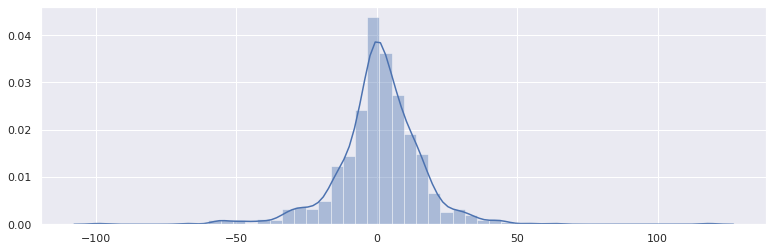

In [54]:
sns.distplot((residuals_timeseries),bins=50);

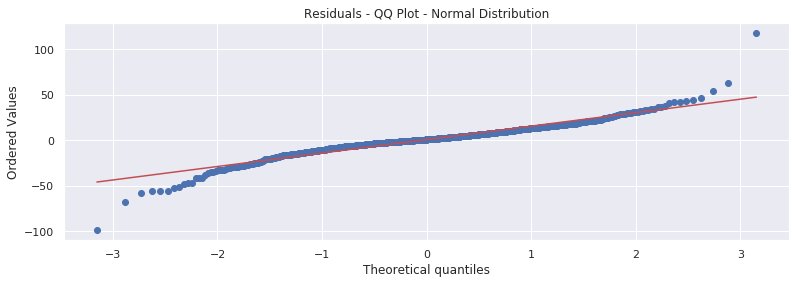

In [46]:
stats.probplot(residuals_timeseries, dist="norm", plot=plt)
plt.title('Residuals - QQ Plot - Normal Distribution')
plt.show()


---
## Stationary Tests



In [47]:
# Augmented Dickey Fuller Test
# H0: There is a unit root for the series (non stationary)
# Test for no constant, no trend. Reject H0 if p-value of less than 5%.
statsmodels.tsa.stattools.adfuller(residuals_timeseries, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-10.644122121373616,
 4.0301069141070444e-19,
 10,
 845,
 {'1%': -2.5683909968138368,
  '10%': -1.6165094394221937,
  '5%': -1.9413225307933255},
 6934.770505985956)

---
## Autocorrelation Tests

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


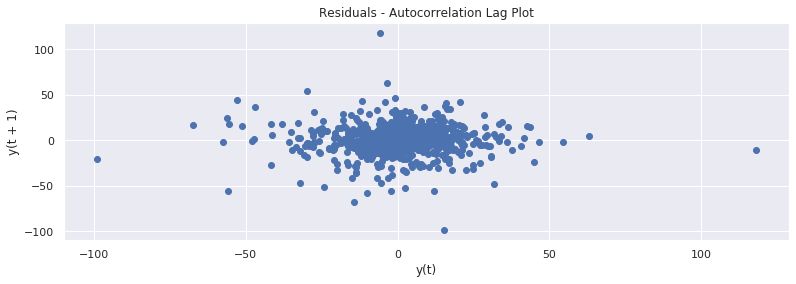

In [59]:
lag_plot(residuals_timeseries)
plt.title('Residuals - Autocorrelation Lag Plot')
plt.show()

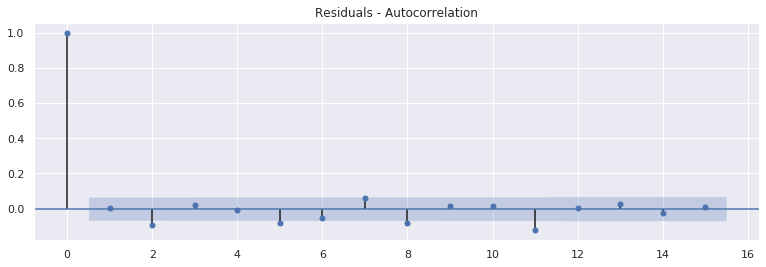

In [49]:
sns.set(rc={'figure.figsize':(13, 4)})
sm.graphics.tsa.plot_acf(residuals_timeseries.squeeze(), lags=15)
plt.title('Residuals - Autocorrelation')
plt.show()

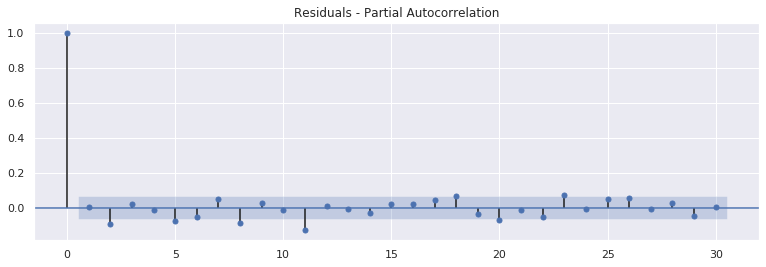

In [50]:
# Partial Autocorrelation Plot
plot_pacf(residuals_timeseries)
plt.title('Residuals - Partial Autocorrelation')
plt.show()

---
# Appendix



## / Correlatio (Covariance?) Tests

The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.

## / Mean different from zero?


t test

https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f

https://pythonfordatascience.org/independent-t-test-python/

## / constant variance test